## E-commerce.

#### Goals:
* Exploratory analysis
* Cohort segmentation
* RFM-analysis segmentation

#### Data description:

`olist_customers_datase.csv` — table with unique user ids
* `customer_id` — user id by orders 
* `customer_unique_id` — unique user ids
* `customer_zip_code_prefix` —  postcode
* `customer_city` —  user's city for delivery 
* `customer_state` —  user's state for delivery

`olist_orders_dataset.csv` —  table with orders

* `order_id` —  unique order id (receipt number)
* `customer_id` —  user id by orders
* `order_status` —  order status
    * created
    * approved
    * invoiced
    * processing
    * shipped
    * delivered
    * unavailable
    * canceled
* `order_purchase_timestamp` —  order created timestamp
* `order_approved_at` —  payment approved timestamp
* `order_delivered_carrier_date` —  transfer to carrier timestamp
* `order_delivered_customer_date` —  delivered to customer timestamp
* `order_estimated_delivery_date` —  estimated delivery timestamp

`olist_order_items_dataset.csv` —  items available to order
* `order_id` —  unique order id (receipt number)
* `order_item_id` —  item number within an order
* `product_id` —  item id
* `seller_id` — seller id
* `shipping_limit_date` —  deadline for the seller to trasfer the order to the logistics partner
* `price` —  price per item
* `freight_value` —  item weight


NB: Not all the columns will be used in the analysis.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import calendar

import requests
from urllib.parse import urlencode

from datetime import timedelta
import matplotlib.pyplot as plt

In [2]:
# Getting links to download the datasets

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

public_keys = ['https://disk.yandex.ru/d/FUi5uSd6BfG_ig', 
               'https://disk.yandex.ru/d/t9Li4JOfgxuUrg', 
               'https://disk.yandex.ru/d/Gbt-yAcQrOe3Pw']

urls = []
for key in public_keys:
    final_url = base_url + urlencode(dict(public_key=key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    urls.append(download_url)

download_url_customers = urls[0]
download_url_orders = urls[1]
download_url_order_items = urls[2] 

In [3]:
customers = pd.read_csv(download_url_customers)

In [4]:
orders = pd.read_csv(download_url_orders)

In [5]:
order_items = pd.read_csv(download_url_order_items)

Sneak peek at the data and define what should be considered to be a purchase.

In [6]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [7]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [8]:
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [9]:
customers.dtypes

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

In [10]:
orders.dtypes

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

In [11]:
order_items.dtypes

order_id                object
order_item_id            int64
product_id              object
seller_id               object
shipping_limit_date     object
price                  float64
freight_value          float64
dtype: object

Override types of variables containing dates from object to datetime.

In [12]:
orders[['order_purchase_timestamp', 
                 'order_approved_at',
                 'order_delivered_carrier_date',
                 'order_delivered_customer_date',
                 'order_estimated_delivery_date']] = orders[['order_purchase_timestamp', 
                 'order_approved_at',
                 'order_delivered_carrier_date',
                 'order_delivered_customer_date',
                 'order_estimated_delivery_date']].apply(pd.to_datetime)

In [13]:
order_items[['shipping_limit_date']] = order_items[['shipping_limit_date']].apply(pd.to_datetime)

Take a closer look at orders table.

In [14]:
orders.order_status.value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

In [15]:
orders.order_approved_at.isna().sum()

160

Let's define purchases as orders that are neither `canceled` nor `unavailable` and have a timestamp in `order_approved_at` column (so, they are paid).

In [16]:
orders_filtered = orders.dropna(subset=['order_approved_at'])

In [17]:
# check
orders_filtered.order_approved_at.isna().sum()

0

In [18]:
excluded_statuses = ['canceled', 'unavailable']

orders_filtered = orders_filtered.query('order_status not in @excluded_statuses')

In [19]:
orders_filtered.order_status.value_counts()

delivered     96464
shipped        1107
invoiced        314
processing      301
approved          2
Name: order_status, dtype: int64

Data cleaning and preparation is complete. Let's do some exploratory analysis.

### 1. How many users purchased only once?

In [20]:
# As long as customer_id is unique for every order, we won't get enouh information from orders table only
# We need to merge it with customers table

In [21]:
# I won't use the whole table and merge only usuful columns

customers.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state'],
      dtype='object')

In [22]:
merged = orders_filtered.merge(customers.drop(columns=['customer_zip_code_prefix',
       'customer_city', 'customer_state']))

In [23]:
merged.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6


In [24]:
merged.groupby('customer_unique_id', as_index=False) \
    .agg({'order_id': 'count'}) \
    .rename(columns={'order_id': 'purchases'}) \
    .query('purchases == 1') \
    .shape[0]

92087

There are 92,087 users who only made one transaction.

### 2. How many orders do not get delivered on average? What are the reasons? Print the detailed information. 

In [25]:
# create a new table, so the original data will be untouched

not_delivered_orders = orders

In [26]:
# data types are correct

not_delivered_orders.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [27]:
not_delivered_orders['order_year'] = not_delivered_orders.order_estimated_delivery_date.dt.year
not_delivered_orders['order_month'] = not_delivered_orders.order_estimated_delivery_date.dt.month

In [28]:
not_delivered_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_year,order_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017,10
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,2018,8
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,2018,9
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,2017,12
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2018,2


In [29]:
not_delivered_orders.groupby(['order_year', 'order_month', 'order_status'], as_index=False) \
    .agg({'order_id': 'nunique'}) \
    .pivot(index=['order_year', 'order_month'], columns='order_status', values='order_id') \
    .loc[:, ['canceled', 'unavailable']] \
    .fillna(0).mean()

order_status
canceled       23.148148
unavailable    22.555556
dtype: float64

There are on average 45 orders that do not get delivered monthly (either canceled or unavailable).

### 3. For each product, determine on which day of the week the product is purchased most often.

In [30]:
# Take a look at the orders data set

orders_filtered.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [31]:
# Need to merge orders table with order_items table. Taking a look at the columns that need to be dropped

order_items.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')

In [32]:
order_items_merged = orders_filtered.merge(order_items.drop(columns=['order_item_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value']))

In [33]:
order_items_merged

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,87285b34884572647811a353c7ac498a
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,595fac2a385ac33a80bd5114aec74eb8
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,aa4383b373c6aca5d8797843e5594415
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,d0b61bfb1de832b15ba9d266ca96e5b0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,65266b2da20d04dbe00c5c2d3bb7859e
...,...,...,...,...,...,...,...,...,...
112081,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,f1d4ce8c6dd66c47bbaa8c6781c2a923
112082,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,b80910977a37536adeddd63663f916ad
112083,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,d1c427060a0f73f6b889a5c7c61f2ac4
112084,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,d1c427060a0f73f6b889a5c7c61f2ac4


The purchase is complete if the payment has gone through (there is a date in order_approved_at column).

In [34]:
# Add a column with the day of the week
 
order_items_merged['day_of_week'] = order_items_merged['order_approved_at'].dt.strftime("%A")

In [35]:
# Result table

order_items_merged.groupby(['product_id', 'day_of_week'], as_index=False) \
    .agg({'order_id': 'count'}) \
    .sort_values('order_id', ascending=False) \
    .groupby('product_id') \
    .head(1) \
    .rename(columns={'order_id': 'purchases'})

,product_id,day_of_week,purchases
40850,aca2eb7d00ea1a7b8ebd4e68314663af,Tuesday,119
20036,53b36df67ebb7c41585e8d54d6772e08,Tuesday,105
15844,422879e10f46682990de24d770e7f83d,Tuesday,89
36363,99a4788cb24856965c36a24e339b6058,Tuesday,82
12996,368c6c730842d78016ad823897a372db,Thursday,80
...,...,...,...
23840,63dfa8b12200610ed7b5e41d3c888a25,Saturday,1
23844,63e51e65ec59b56039c6427eed73dcf0,Tuesday,1
23845,63eb97106bfe47fe857edcf78f3e3e08,Saturday,1
23855,63f52009dc3ddb733394e80183aed0f0,Saturday,1


### 4. Purchases by day of week.

In [36]:
# Looking at the distribution of purchases

q = order_items_merged.groupby(['product_id', 'day_of_week'], as_index=False) \
            .agg({'order_id': 'count'}) \
            .sort_values('order_id', ascending=False) \
            .groupby('product_id') \
            .head(1) \
            .rename(columns={'order_id': 'purchases'}) \
            .day_of_week.value_counts()

In [37]:
q

Tuesday      6091
Friday       5534
Thursday     4961
Wednesday    4733
Monday       4605
Saturday     4025
Sunday       2777
Name: day_of_week, dtype: int64

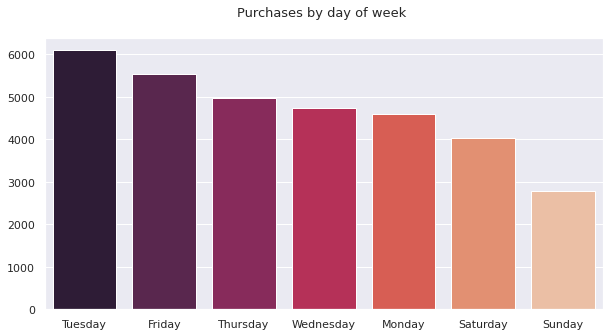

In [119]:
sns.set(rc={'figure.figsize':(10,5)})
plt.title('Purchases by day of week \n', fontsize = 13)


sns.barplot(x=q.index, y=q.values, palette='rocket')

TOP-3 most popular days for purchases are Tuesday, Friday and Thursday.

### 5. How many purchases does each user have on average per week (by month)? Considering that there may not be a whole number of weeks within a month.


In [39]:
# Looking at the data again

merged.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6


In [40]:
# Create a new columns with month and year of puchase, will group by it later 

merged['purchase_year_month'] = merged.order_approved_at.dt.to_period('M')

In [41]:
# Number of purchases by customer in every month

purchases_by_month = merged \
                .groupby(['customer_unique_id', 'purchase_year_month'], as_index=False) \
                .agg({'order_id': 'count'}) \
                .rename(columns={'order_id': 'purchases'})

In [42]:
purchases_by_month

,customer_unique_id,purchase_year_month,purchases
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,1
2,0000f46a3911fa3c0805444483337064,2017-03,1
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,1
4,0004aac84e0df4da2b147fca70cf8255,2017-11,1
...,...,...,...
96841,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06,1
96842,fffea47cd6d3cc0a88bd621562a9d061,2017-12,1
96843,ffff371b4d645b6ecea244b27531430a,2017-02,1
96844,ffff5962728ec6157033ef9805bacc48,2018-05,1


In [43]:
# Function to calculate the amount of weeks in each month

def weeks_in_month(date):
    year = date.year
    month = date.month
    days_in_month = calendar.monthrange(year, month)[1]
    return round(days_in_month / 7, 2)

In [44]:
# New column with the amount of weeks 

purchases_by_month['weeks_in_month'] = purchases_by_month \
    .purchase_year_month.apply(lambda x: weeks_in_month(x))

In [45]:
# Look at the result

purchases_by_month.sort_values('purchases')

,customer_unique_id,purchase_year_month,purchases,weeks_in_month
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,1,4.43
64358,a9dd5adb51c5a1a637afbebf0dd554be,2018-04,1,4.29
64357,a9dd2b5b5bd99f1475a6bfc3b5837efc,2017-10,1,4.43
64356,a9db167d8824c6068bf31c6858dc2a11,2018-04,1,4.29
64355,a9da5a115fdd7b13412153e54dc02604,2018-04,1,4.29
...,...,...,...,...
68541,b4e4f24de1e8725b74e4a1f4975116ed,2018-02,4,4.00
23648,3e43e6105506432c953e165fb2acf44c,2018-02,4,4.00
14310,25a560b9a6006157838aab1bdbd68624,2017-04,4,4.29
61437,a239b8e2fbce33780f1f1912e2ee5275,2017-02,4,4.00


In [46]:
# Average purchases per week

purchases_by_month['purchases_per_week'] = purchases_by_month.purchases / purchases_by_month.weeks_in_month

In [47]:
purchases_by_month

,customer_unique_id,purchase_year_month,purchases,weeks_in_month,purchases_per_week
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,1,4.43,0.225734
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,1,4.43,0.225734
2,0000f46a3911fa3c0805444483337064,2017-03,1,4.43,0.225734
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,1,4.43,0.225734
4,0004aac84e0df4da2b147fca70cf8255,2017-11,1,4.29,0.233100
...,...,...,...,...,...
96841,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06,1,4.29,0.233100
96842,fffea47cd6d3cc0a88bd621562a9d061,2017-12,1,4.43,0.225734
96843,ffff371b4d645b6ecea244b27531430a,2017-02,1,4.00,0.250000
96844,ffff5962728ec6157033ef9805bacc48,2018-05,1,4.43,0.225734


Let's plot the result and check whether there are any differences in purchases between months. 

In [48]:
# Take avg of purchases per month

a = purchases_by_month.groupby('purchase_year_month') \
        .agg({'purchases_per_week': 'mean'})

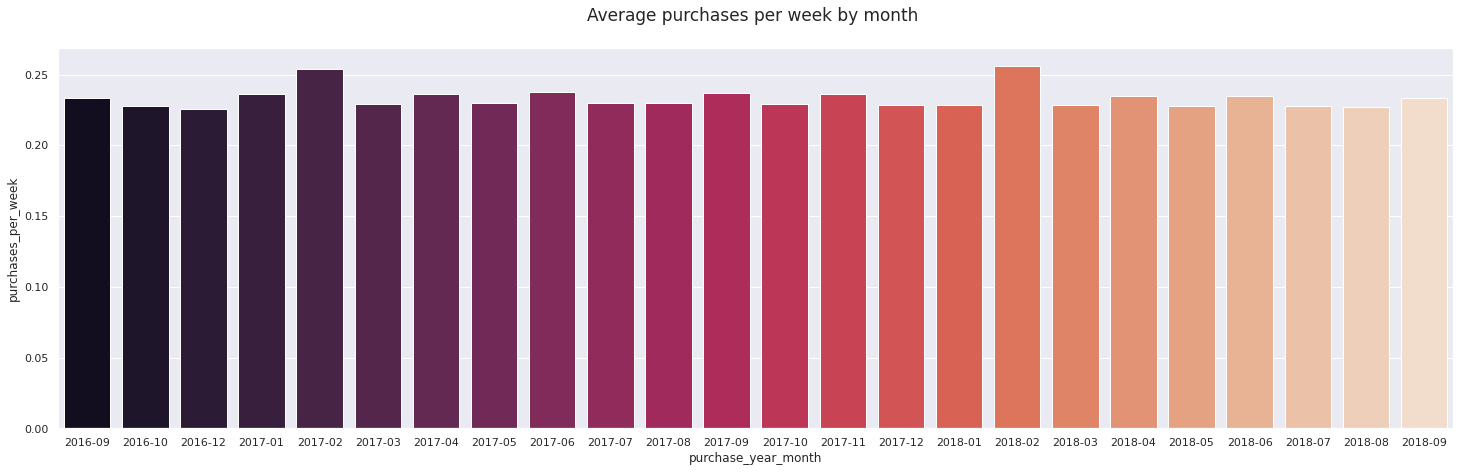

In [116]:
sns.set(rc={'figure.figsize':(25,7)})
plt.title('Average purchases per week by month \n', fontsize = 17)

sns.barplot(x=a.index, y=a.purchases_per_week, palette='rocket')

Generally, there are no seasonal fluctuations and sales are almost equally spread throughout the whole period of observation. There are two small spikes in February but it is probably because there are less weeks in February.

### 6. Conduct a cohort analysis of users. From January to December identify the cohort with the highest retention for the 3rd month.

In [50]:
# Sneak peek at the data again

merged.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,purchase_year_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,2017-10
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,2018-07
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,2018-08
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,2017-11
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,2018-02


In [51]:
# Get rid of unneccessary columns

cohort_analysis = merged.drop(columns=['order_status',
                                          'order_purchase_timestamp',
                                          'order_delivered_carrier_date', 
                                          'order_delivered_customer_date', 
                                          'order_estimated_delivery_date'])

In [52]:
cohort_analysis

,order_id,customer_id,order_approved_at,customer_unique_id,purchase_year_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 11:07:15,7c396fd4830fd04220f754e42b4e5bff,2017-10
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-26 03:24:27,af07308b275d755c9edb36a90c618231,2018-07
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:55:23,3a653a41f6f9fc3d2a113cf8398680e8,2018-08
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:45:59,7c142cf63193a1473d2e66489a9ae977,2017-11
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 22:20:29,72632f0f9dd73dfee390c9b22eb56dd6,2018-02
...,...,...,...,...,...
98183,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,2017-03-09 09:54:05,6359f309b166b0196dbf7ad2ac62bb5a,2017-03
98184,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,2018-02-06 13:10:37,da62f9e57a76d978d02ab5362c509660,2018-02
98185,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,2017-08-27 15:04:16,737520a9aad80b3fbbdad19b66b37b30,2017-08
98186,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,2018-01-08 21:36:21,5097a5312c8b157bb7be58ae360ef43c,2018-01


In [53]:
# Look at the distribution of purchases by year-month

cohort_analysis.purchase_year_month.value_counts()

2017-11    7280
2018-03    7249
2018-01    7108
2018-05    7026
2018-04    6758
2018-02    6604
2018-08    6575
2018-06    6142
2018-07    6125
2017-12    5782
2017-10    4512
2017-08    4296
2017-09    4248
2017-07    3899
2017-05    3642
2017-06    3214
2017-03    2626
2017-04    2352
2017-02    1703
2017-01     750
2016-10     294
2016-09       1
2018-09       1
2016-12       1
Freq: M, Name: purchase_year_month, dtype: int64

In [54]:
# Customers cohort will be defined by the date of their first purchase

cohort_analysis['first_purchase_date'] = cohort_analysis \
    .groupby('customer_unique_id')['purchase_year_month'] \
    .transform('min')

In [55]:
cohort_analysis

,order_id,customer_id,order_approved_at,customer_unique_id,purchase_year_month,first_purchase_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 11:07:15,7c396fd4830fd04220f754e42b4e5bff,2017-10,2017-09
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-26 03:24:27,af07308b275d755c9edb36a90c618231,2018-07,2018-07
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:55:23,3a653a41f6f9fc3d2a113cf8398680e8,2018-08,2018-08
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:45:59,7c142cf63193a1473d2e66489a9ae977,2017-11,2017-11
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 22:20:29,72632f0f9dd73dfee390c9b22eb56dd6,2018-02,2018-02
...,...,...,...,...,...,...
98183,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,2017-03-09 09:54:05,6359f309b166b0196dbf7ad2ac62bb5a,2017-03,2017-03
98184,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,2018-02-06 13:10:37,da62f9e57a76d978d02ab5362c509660,2018-02,2018-02
98185,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,2017-08-27 15:04:16,737520a9aad80b3fbbdad19b66b37b30,2017-08,2017-08
98186,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,2018-01-08 21:36:21,5097a5312c8b157bb7be58ae360ef43c,2018-01,2018-01


In [56]:
# Month difference between the first purchase and the current one

cohort_analysis['months_diff'] = cohort_analysis['purchase_year_month'] \
                                    .subtract(cohort_analysis['first_purchase_date']) \
                                    .apply(lambda x: x.n)

In [57]:
cohort_analysis

,order_id,customer_id,order_approved_at,customer_unique_id,purchase_year_month,first_purchase_date,months_diff
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 11:07:15,7c396fd4830fd04220f754e42b4e5bff,2017-10,2017-09,1
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-26 03:24:27,af07308b275d755c9edb36a90c618231,2018-07,2018-07,0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:55:23,3a653a41f6f9fc3d2a113cf8398680e8,2018-08,2018-08,0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:45:59,7c142cf63193a1473d2e66489a9ae977,2017-11,2017-11,0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 22:20:29,72632f0f9dd73dfee390c9b22eb56dd6,2018-02,2018-02,0
...,...,...,...,...,...,...,...
98183,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,2017-03-09 09:54:05,6359f309b166b0196dbf7ad2ac62bb5a,2017-03,2017-03,0
98184,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,2018-02-06 13:10:37,da62f9e57a76d978d02ab5362c509660,2018-02,2018-02,0
98185,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,2017-08-27 15:04:16,737520a9aad80b3fbbdad19b66b37b30,2017-08,2017-08,0
98186,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,2018-01-08 21:36:21,5097a5312c8b157bb7be58ae360ef43c,2018-01,2018-01,0


In [58]:
# Define customer cohort by the first purchase, count the amount of customers purchasing in every subsequent month

cohort_table = cohort_analysis \
    .pivot_table(index='first_purchase_date',
                 columns='months_diff',
                 values='customer_unique_id',
                 aggfunc='nunique')

In [59]:
cohort_table

months_diff,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
first_purchase_date,,,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,291.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,NaN,1.0,2.0,2.0
2016-12,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,716.0,4.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,NaN,2.0,2.0,5.0,3.0,1.0,1.0,2.0,3.0,1.0,NaN
2017-02,1674.0,4.0,4.0,3.0,7.0,2.0,4.0,3.0,1.0,3.0,2.0,5.0,2.0,3.0,2.0,1.0,1.0,4.0,NaN,NaN
2017-03,2580.0,13.0,9.0,9.0,9.0,4.0,4.0,8.0,8.0,3.0,10.0,3.0,6.0,3.0,4.0,6.0,2.0,4.0,NaN,NaN
2017-04,2301.0,14.0,5.0,4.0,6.0,6.0,8.0,6.0,8.0,4.0,5.0,2.0,2.0,1.0,2.0,2.0,3.0,NaN,NaN,NaN
2017-05,3543.0,19.0,17.0,14.0,11.0,12.0,15.0,5.0,9.0,9.0,10.0,12.0,7.0,2.0,7.0,8.0,NaN,NaN,NaN,NaN
2017-06,3110.0,14.0,11.0,12.0,8.0,11.0,11.0,7.0,4.0,7.0,10.0,11.0,5.0,4.0,6.0,NaN,NaN,NaN,NaN,NaN


In [60]:
# Use purchases in month 0 to calculate percentages

divisor = cohort_table.iloc[:,0]

In [61]:
retention = cohort_table.divide(divisor, axis='index') 

In [62]:
retention

months_diff,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
first_purchase_date,,,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,1.0,NaN,NaN,NaN,NaN,NaN,0.003436,NaN,NaN,0.003436,NaN,0.003436,NaN,0.003436,NaN,0.003436,NaN,0.003436,0.006873,0.006873
2016-12,1.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,1.0,0.005587,0.002793,0.001397,0.004190,0.001397,0.004190,0.001397,0.001397,NaN,0.002793,0.002793,0.006983,0.004190,0.001397,0.001397,0.002793,0.004190,0.001397,NaN
2017-02,1.0,0.002389,0.002389,0.001792,0.004182,0.001195,0.002389,0.001792,0.000597,0.001792,0.001195,0.002987,0.001195,0.001792,0.001195,0.000597,0.000597,0.002389,NaN,NaN
2017-03,1.0,0.005039,0.003488,0.003488,0.003488,0.001550,0.001550,0.003101,0.003101,0.001163,0.003876,0.001163,0.002326,0.001163,0.001550,0.002326,0.000775,0.001550,NaN,NaN
2017-04,1.0,0.006084,0.002173,0.001738,0.002608,0.002608,0.003477,0.002608,0.003477,0.001738,0.002173,0.000869,0.000869,0.000435,0.000869,0.000869,0.001304,NaN,NaN,NaN
2017-05,1.0,0.005363,0.004798,0.003951,0.003105,0.003387,0.004234,0.001411,0.002540,0.002540,0.002822,0.003387,0.001976,0.000564,0.001976,0.002258,NaN,NaN,NaN,NaN
2017-06,1.0,0.004502,0.003537,0.003859,0.002572,0.003537,0.003537,0.002251,0.001286,0.002251,0.003215,0.003537,0.001608,0.001286,0.001929,NaN,NaN,NaN,NaN,NaN


In [63]:
# Filter one full year

retention = retention.loc['2017-01': '2017-12']

In [64]:
# Converting to percentages

retention.round(4)*100

months_diff,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19,20
first_purchase_date,,,,,,,,,,,,,,,,,,,,
2017-01,100.0,0.56,0.28,0.14,0.42,0.14,0.42,0.14,0.14,NaN,0.28,0.28,0.70,0.42,0.14,0.14,0.28,0.42,0.14,NaN
2017-02,100.0,0.24,0.24,0.18,0.42,0.12,0.24,0.18,0.06,0.18,0.12,0.30,0.12,0.18,0.12,0.06,0.06,0.24,NaN,NaN
2017-03,100.0,0.50,0.35,0.35,0.35,0.16,0.16,0.31,0.31,0.12,0.39,0.12,0.23,0.12,0.16,0.23,0.08,0.16,NaN,NaN
2017-04,100.0,0.61,0.22,0.17,0.26,0.26,0.35,0.26,0.35,0.17,0.22,0.09,0.09,0.04,0.09,0.09,0.13,NaN,NaN,NaN
2017-05,100.0,0.54,0.48,0.40,0.31,0.34,0.42,0.14,0.25,0.25,0.28,0.34,0.20,0.06,0.20,0.23,NaN,NaN,NaN,NaN
2017-06,100.0,0.45,0.35,0.39,0.26,0.35,0.35,0.23,0.13,0.23,0.32,0.35,0.16,0.13,0.19,NaN,NaN,NaN,NaN,NaN
2017-07,100.0,0.53,0.32,0.19,0.34,0.19,0.32,0.11,0.19,0.24,0.21,0.29,0.13,0.26,NaN,NaN,NaN,NaN,NaN,NaN
2017-08,100.0,0.67,0.36,0.26,0.39,0.53,0.26,0.26,0.12,0.17,0.24,0.17,0.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,100.0,0.66,0.49,0.34,0.41,0.27,0.22,0.22,0.32,0.17,0.27,0.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


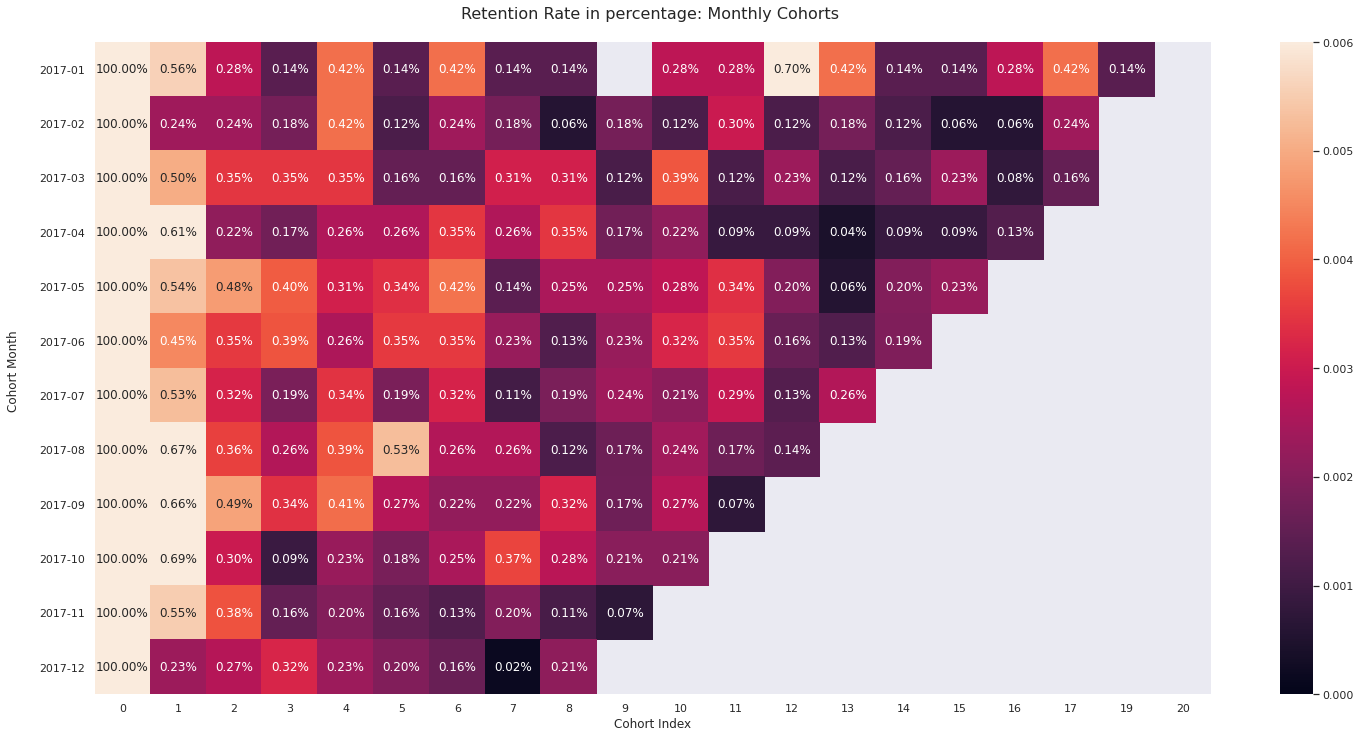

In [65]:
# Visualisation

plt.figure(figsize=(25, 12))

plt.title('Retention Rate in percentage: Monthly Cohorts \n', fontsize = 16)

sns.heatmap(retention, annot=True, fmt= '.2%', vmin = 0.0 , vmax = 0.006)
plt.ylabel('Cohort Month \n')
plt.xlabel('Cohort Index')
plt.yticks(rotation=0)
plt.show()

The highest retention in the third month is in the cohort 2017-05 and amounted to 0.40%.

### 7. Build RFM segmentation of users to evaluate your audience qualitatively.

#### Let R be the time from the user's last purchase to the current date, <br> F be the total number of purchases of the user, <br> M be the sum of money spent.

In [66]:
# Sneak peek at the data

merged.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,purchase_year_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,2017-10
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,2018-07
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,2018-08
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,2017-11
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,2018-02


In [68]:
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [74]:
# Since we do not have data on the number of goods in each order (there is only the sequence number of the 
# goods in the order - order_item_id), first we will find the amount of a certain product in a particular 
# order and its price 

# NB the price of the product varies from order to order due to promo codes, personal discounts, 
# price changes over time and etc.


sold_per_order = order_items.groupby(['order_id', 'product_id', 'price'], as_index=False) \
    .agg({'order_item_id': 'count'}) \
    .rename(columns={'order_item_id': 'amount'})

In [75]:
sold_per_order

,order_id,product_id,price,amount
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,58.90,1
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,239.90,1
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,199.00,1
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,12.99,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,199.90,1
...,...,...,...,...
102420,fffc94f6ce00a00581880bf54a75a037,4aa6014eceb682077f9dc4bffebc05b0,299.99,1
102421,fffcd46ef2263f404302a634eb57f7eb,32e07fd915822b0765e448c4dd74c828,350.00,1
102422,fffce4705a9662cd70adb13d4a31832d,72a30483855e2eafc67aee5dc2560482,99.90,1
102423,fffe18544ffabc95dfada21779c9644f,9c422a519119dcad7575db5af1ba540e,55.99,1


In [77]:
sold_per_order['total'] = sold_per_order.amount * sold_per_order.price

In [78]:
# Find the total sum for each order

sold_per_order = sold_per_order.groupby(['order_id'], as_index=False) \
                 .agg({'total': 'sum'}) \
                 .rename(columns={'total': 'total_sum_order'}) 

sold_per_order

,order_id,total_sum_order
0,00010242fe8c5a6d1ba2dd792cb16214,58.90
1,00018f77f2f0320c557190d7a144bdd3,239.90
2,000229ec398224ef6ca0657da4fc703e,199.00
3,00024acbcdf0a6daa1e931b038114c75,12.99
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90
...,...,...
98661,fffc94f6ce00a00581880bf54a75a037,299.99
98662,fffcd46ef2263f404302a634eb57f7eb,350.00
98663,fffce4705a9662cd70adb13d4a31832d,99.90
98664,fffe18544ffabc95dfada21779c9644f,55.99


In [79]:
# Merge items table with orders table
# But first get rid of unnecessary columns

merged.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'customer_unique_id', 'purchase_year_month'],
      dtype='object')

In [80]:
rfm_analysis = merged.drop(columns=['customer_id', 'order_status', 'order_purchase_timestamp', 
                                    'order_delivered_carrier_date',
                                    'order_delivered_customer_date', 
                                    'order_estimated_delivery_date',
                                    'purchase_year_month']) \
                     .merge(sold_per_order)

In [81]:
rfm_analysis

,order_id,order_approved_at,customer_unique_id,total_sum_order
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 11:07:15,7c396fd4830fd04220f754e42b4e5bff,29.99
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-26 03:24:27,af07308b275d755c9edb36a90c618231,118.70
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:55:23,3a653a41f6f9fc3d2a113cf8398680e8,159.90
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:45:59,7c142cf63193a1473d2e66489a9ae977,45.00
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 22:20:29,72632f0f9dd73dfee390c9b22eb56dd6,19.90
...,...,...,...,...
98180,9c5dedf39a927c1b2549525ed64a053c,2017-03-09 09:54:05,6359f309b166b0196dbf7ad2ac62bb5a,72.00
98181,63943bddc261676b46f01ca7ac2f7bd8,2018-02-06 13:10:37,da62f9e57a76d978d02ab5362c509660,174.90
98182,83c1379a015df1e13d02aae0204711ab,2017-08-27 15:04:16,737520a9aad80b3fbbdad19b66b37b30,205.99
98183,11c177c8e97725db2631073c19f07b62,2018-01-08 21:36:21,5097a5312c8b157bb7be58ae360ef43c,359.98


In [82]:
# To measure Recency in RFM analysis, we need to select some date for the reference point. If the data were fresh,
# then we could take the current date, but since the last record is older than 3 years, we will take the last date 
# in the dataset + 3 days. It will be the reference point.

TODAY = rfm_analysis['order_approved_at'].max() + timedelta(days=3)

In [85]:
TODAY

Timestamp('2018-09-06 17:40:06')

In [88]:
# Add new column with the amount of days since the current purchase

rfm_analysis['days_since_order'] = (TODAY - rfm_analysis.order_approved_at).dt.days

In [89]:
rfm_analysis

,order_id,order_approved_at,customer_unique_id,total_sum_order,days_since_order
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 11:07:15,7c396fd4830fd04220f754e42b4e5bff,29.99,339
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-26 03:24:27,af07308b275d755c9edb36a90c618231,118.70,42
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:55:23,3a653a41f6f9fc3d2a113cf8398680e8,159.90,29
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:45:59,7c142cf63193a1473d2e66489a9ae977,45.00,291
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 22:20:29,72632f0f9dd73dfee390c9b22eb56dd6,19.90,204
...,...,...,...,...,...
98180,9c5dedf39a927c1b2549525ed64a053c,2017-03-09 09:54:05,6359f309b166b0196dbf7ad2ac62bb5a,72.00,546
98181,63943bddc261676b46f01ca7ac2f7bd8,2018-02-06 13:10:37,da62f9e57a76d978d02ab5362c509660,174.90,212
98182,83c1379a015df1e13d02aae0204711ab,2017-08-27 15:04:16,737520a9aad80b3fbbdad19b66b37b30,205.99,375
98183,11c177c8e97725db2631073c19f07b62,2018-01-08 21:36:21,5097a5312c8b157bb7be58ae360ef43c,359.98,240


In [90]:
# Final table 
# For Recency take the latest order (least number of days since purchase)
# For Frequency - the amount of all orders by the customer
# For Monetary - sum of all purchases

rfm = rfm_analysis.groupby('customer_unique_id', as_index=False) \
            .agg({'days_since_order': 'min', 
                  'order_id': 'count',
                  'total_sum_order': 'sum'}) \
            .rename(columns={'days_since_order': 'recency', 
                             'order_id': 'frequency',
                             'total_sum_order': 'monetary'}) 

In [91]:
rfm

,customer_unique_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,119,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,121,1,18.90
2,0000f46a3911fa3c0805444483337064,544,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,328,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,295,1,180.00
...,...,...,...,...
94965,fffcf5a5ff07b0908bd4e2dbc735a684,454,1,1570.00
94966,fffea47cd6d3cc0a88bd621562a9d061,269,1,64.89
94967,ffff371b4d645b6ecea244b27531430a,576,1,89.90
94968,ffff5962728ec6157033ef9805bacc48,127,1,115.00


Now let's define the limits for each segment. I want those limits to be adaptive, so instead
of absolute values I will use relative quantiles.
<br>Each quantile will contain a third of the sample.

In [92]:
rfm.describe()

,recency,frequency,monetary
count,94970.000000,94970.000000,94970.000000
mean,245.475519,1.033853,142.073605
std,152.952043,0.210801,216.085833
min,3.000000,1.000000,0.850000
25%,121.000000,1.000000,47.900000
50%,226.000000,1.000000,89.890000
75%,354.000000,1.000000,155.000000
max,721.000000,16.000000,13440.000000


It seems that not all limits can be set based on quantiles. For frequency, the boundaries of all three quantiles coincide. They will have to be set manually, hence they will be absolute and not relative.

In [93]:
rfm['R'] = pd.qcut(rfm.recency, 3, labels=['1', '2', '3'])

In [153]:
# Frequency

# 96% of all customers bought only once
# 2.7% - 2 times
# 1.3% - more than 2

rfm.frequency.value_counts(normalize=True)

1     0.969611
2     0.027904
3     0.001980
4     0.000305
5     0.000095
6     0.000053
7     0.000032
16    0.000011
9     0.000011
Name: frequency, dtype: float64

Since we have such rare purchases (48 times fewer customers make the second order, and ~ 10 times
fewer make the third), each subsequent purchase has a high weight for us and it is worth placing
the boundaries of clusters as follows: 1, 2, 2+. In this case, 2+ cluster will be very important
to us, because they will be those rare 1% of buyers.

In [94]:
rfm['F'] = pd.cut(rfm.frequency, bins=[0, 1, 2, 30], labels=['1', '2', '3'])

In [95]:
rfm['M'] = pd.qcut(rfm.monetary, 3, labels=['1', '2', '3'])

In [96]:
# define the final RFM

rfm['RFM'] = rfm['R'].astype(str) + \
             rfm['F'].astype(str) + \
             rfm['M'].astype(str)

In [98]:
rfm

,customer_unique_id,recency,frequency,monetary,R,F,M,RFM
0,0000366f3b9a7992bf8c76cfdf3221e2,119,1,129.90,1,1,3,113
1,0000b849f77a49e4a4ce2b2a4ca5be3f,121,1,18.90,1,1,1,111
2,0000f46a3911fa3c0805444483337064,544,1,69.00,3,1,2,312
3,0000f6ccb0745a6a4b88665a16c9f078,328,1,25.99,3,1,1,311
4,0004aac84e0df4da2b147fca70cf8255,295,1,180.00,2,1,3,213
...,...,...,...,...,...,...,...,...
94965,fffcf5a5ff07b0908bd4e2dbc735a684,454,1,1570.00,3,1,3,313
94966,fffea47cd6d3cc0a88bd621562a9d061,269,1,64.89,2,1,2,212
94967,ffff371b4d645b6ecea244b27531430a,576,1,89.90,3,1,2,312
94968,ffff5962728ec6157033ef9805bacc48,127,1,115.00,1,1,2,112


In [97]:
rfm.RFM.value_counts()

211    10708
312    10523
311    10427
112    10406
111    10401
113     9986
212     9928
213     9885
313     9820
223      638
123      637
323      490
122      241
322      227
222      224
133       96
321       69
121       65
221       59
233       53
333       51
132       13
232        9
332        7
331        6
231        1
Name: RFM, dtype: int64

Let's define the segments:
* `Top customers` - active, many purchases, large sums of orders
* `Active customers` — constantly generate income
* `Emerging customers` – potential for cross-selling and additional sales
* `Unsteady customers` – potential for cross-selling and additional sales depending on the offer
* `Customers at risk` – inactive, but quite frequent and bring high income

Potentially lost customers:
* `Inactive customers` – rare, but high income
* `Lost customers` - inactive, rare, low income

In [99]:
# Dictionary with segments

segments = {'Top customers': ['111', '121', '112', '122'],
            'Active customers': ['131', '132', '113', '123', '133', '114', '124', '134'],
            'Emerging customers': ['211', '221', '231', '212', '222', '232'],
            'Unsteady customers': ['141', '142', '143', '144', '241', '242', '213', '223', '233',
                                   '243', '214', '224', '234', '244'],
            'Customers at risk': ['311', '312', '313', '314', '321', '322', '323', '324', '331',
                                  '332', '341', '342', '411', '412', '413', '414', '421', '422', '423', '424'],
            'Potential lost customers': ['333', '334', '343', '344'],
            'Inactive customers': ['441', '442'],
            'Lost customers': ['443', '444']}

In [102]:
def segmentation(rfm):
    for key, value in segments.items():
        if rfm in value:
            return key

In [103]:
rfm['segment'] = rfm['RFM'].apply(segmentation)
rfm

,customer_unique_id,recency,frequency,monetary,R,F,M,RFM,segment
0,0000366f3b9a7992bf8c76cfdf3221e2,119,1,129.90,1,1,3,113,Active customers
1,0000b849f77a49e4a4ce2b2a4ca5be3f,121,1,18.90,1,1,1,111,Top customers
2,0000f46a3911fa3c0805444483337064,544,1,69.00,3,1,2,312,Customers at risk
3,0000f6ccb0745a6a4b88665a16c9f078,328,1,25.99,3,1,1,311,Customers at risk
4,0004aac84e0df4da2b147fca70cf8255,295,1,180.00,2,1,3,213,Unsteady customers
...,...,...,...,...,...,...,...,...,...
94965,fffcf5a5ff07b0908bd4e2dbc735a684,454,1,1570.00,3,1,3,313,Customers at risk
94966,fffea47cd6d3cc0a88bd621562a9d061,269,1,64.89,2,1,2,212,Emerging customers
94967,ffff371b4d645b6ecea244b27531430a,576,1,89.90,3,1,2,312,Customers at risk
94968,ffff5962728ec6157033ef9805bacc48,127,1,115.00,1,1,2,112,Top customers


In [106]:
# Distribution of customers

b = rfm.segment.value_counts()

In [107]:
b

Customers at risk           31569
Top customers               21113
Emerging customers          20929
Active customers            10732
Unsteady customers          10576
Potential lost customers       51
Name: segment, dtype: int64

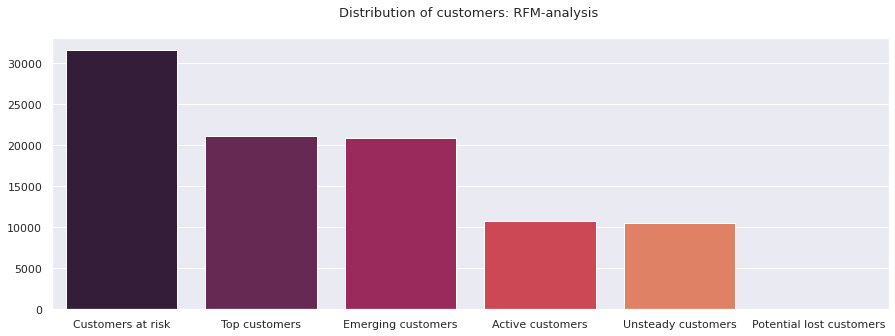

In [111]:
sns.set(rc={'figure.figsize':(15,5)})
plt.title('Distribution of customers: RFM-analysis \n', fontsize = 13)

sns.barplot(x=b.index, y=b.values, palette='rocket')